In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns






In [ ]:
df = pd.read_csv("data/xclan_fitness_usage_dataset.csv")  # the data for data analysis

In [ ]:
print(df.shape)
df.info()
df.describe()
df['dropoff_flag'].value_counts()
# note numbers of yes (dropoff_flag) is not large


(17425, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17425 entries, 0 to 17424
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   17425 non-null  object 
 1   session_date              17425 non-null  object 
 2   session_duration_minutes  17425 non-null  int64  
 3   workout_module_used       17425 non-null  object 
 4   calories_burned           17425 non-null  float64
 5   completed_goal_checkin    17425 non-null  object 
 6   signup_date               17425 non-null  object 
 7   age                       17425 non-null  int64  
 8   gender                    17425 non-null  object 
 9   goal                      17425 non-null  object 
 10  last_login_date           17425 non-null  object 
 11  dropoff_flag              17425 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 1.6+ MB


,count
dropoff_flag,
No,16348
Yes,1077


## EDA


In [38]:
df['dropoff_flag'] = df['dropoff_flag'].map({'Yes': 1, 'No': 0})
df['dropoff_flag'].value_counts(normalize=True)


,proportion
dropoff_flag,
0,0.938192
1,0.061808


Text(0, 0.5, 'Count')

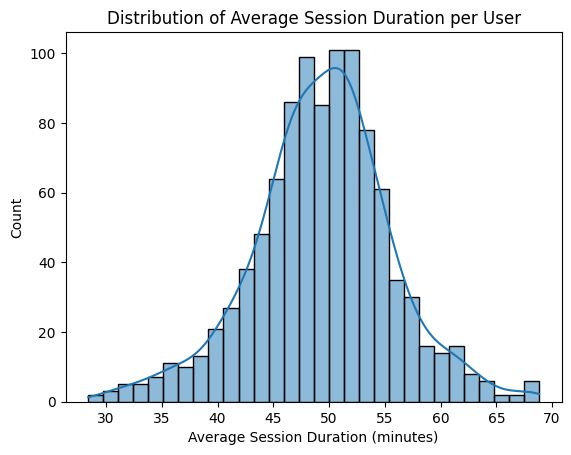

In [40]:
grouped_df = df.groupby('user_id')
sns.histplot(grouped_df['session_duration_minutes'].mean(), bins=30, kde=True)
plt.title("Distribution of Average Session Duration per User")
plt.xlabel("Average Session Duration (minutes)")
plt.ylabel("Count")
# there is no extreme behaviors (noraml distribution)

Text(0, 0.5, 'Avg Session Duration')

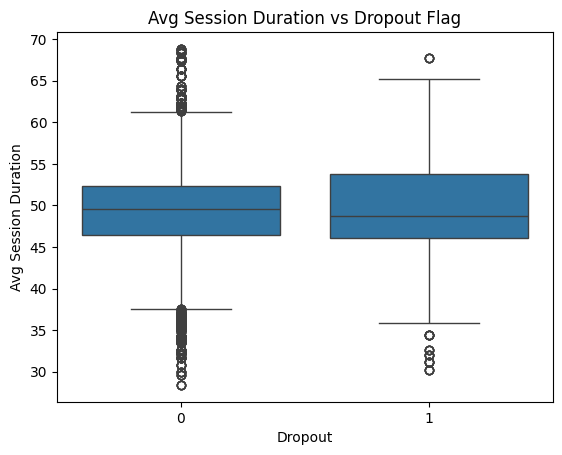

In [ ]:
# Add avg session duration per user
df['avg_duration_per_user'] = df.groupby('user_id')['session_duration_minutes'].transform('mean')

sns.boxplot(x='dropoff_flag', y='avg_duration_per_user', data=df)
plt.title("Avg Session Duration vs Dropout Flag")
plt.xlabel("Dropout")
plt.ylabel("Avg Session Duration")


## getting the required data

In [ ]:
# Convert dates and map chechins
df['session_date'] = pd.to_datetime(df['session_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_login_date'] = pd.to_datetime(df['last_login_date'])

df['completed_goal_checkin'] = df['completed_goal_checkin'].map({'Yes': 1, 'No': 0})
# df['dropoff_flag'] = df['dropoff_flag'].map({'Yes': 1, 'No': 0})

df = df.sort_values(by=['user_id', 'session_date']).reset_index(drop=True)

# Initialize empty columns
df['session_frequency'] = 0.0
df['avg_session_duration'] = 0.0
df['checkin_rate'] = 0.0

# Loop through users
for user_id, user_df in df.groupby('user_id'):
    session_dates = user_df['session_date']
    durations = user_df['session_duration_minutes']
    checkins = user_df['completed_goal_checkin']

    # For each session, calculate past stats
    for i in range(len(user_df)):
        past_sessions = user_df.iloc[:i+1]

        days_range = (past_sessions['session_date'].max() - past_sessions['session_date'].min()).days + 1
        sessions_count = len(past_sessions)

        freq = sessions_count / days_range if days_range > 0 else 1
        avg_time = past_sessions['session_duration_minutes'].mean()
        checkin_avg = past_sessions['completed_goal_checkin'].mean()

        df.loc[past_sessions.index[-1], 'session_frequency'] = freq
        df.loc[past_sessions.index[-1], 'time_spent'] = avg_time
        df.loc[past_sessions.index[-1], 'progress_logs'] = checkin_avg
df

,user_id,session_date,session_duration_minutes,workout_module_used,calories_burned,completed_goal_checkin,signup_date,age,gender,goal,last_login_date,dropoff_flag,avg_duration_per_user,session_frequency,avg_session_duration,checkin_rate,time_spent,progress_logs
0,U0001,2025-05-13,30,Strength,153.41,0,2025-06-03,43,M,Build Muscle,2025-07-30,0,47.066667,1.000000,0.0,0.0,30.000000,0.000000
1,U0001,2025-05-15,66,Cardio,339.89,0,2025-06-03,43,M,Build Muscle,2025-07-30,0,47.066667,0.666667,0.0,0.0,48.000000,0.000000
2,U0001,2025-05-19,34,Cardio,214.16,1,2025-06-03,43,M,Build Muscle,2025-07-30,0,47.066667,0.428571,0.0,0.0,43.333333,0.333333
3,U0001,2025-05-22,88,Cardio,620.48,0,2025-06-03,43,M,Build Muscle,2025-07-30,0,47.066667,0.400000,0.0,0.0,54.500000,0.250000
4,U0001,2025-05-23,42,Cardio,322.88,1,2025-06-03,43,M,Build Muscle,2025-07-30,0,47.066667,0.454545,0.0,0.0,52.000000,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17420,U1000,2025-05-08,50,Yoga,286.81,1,2025-07-10,35,M,Stay Active,2025-07-05,1,46.200000,1.000000,0.0,0.0,50.000000,1.000000
17421,U1000,2025-05-16,37,HIIT,257.35,1,2025-07-10,35,M,Stay Active,2025-07-05,1,46.200000,0.222222,0.0,0.0,43.500000,1.000000
17422,U1000,2025-05-22,44,Cardio,405.46,1,2025-07-10,35,M,Stay Active,2025-07-05,1,46.200000,0.200000,0.0,0.0,43.666667,1.000000
17423,U1000,2025-06-11,33,Strength,181.38,0,2025-07-10,35,M,Stay Active,2025-07-05,1,46.200000,0.114286,0.0,0.0,41.000000,0.750000


In [43]:
# make new dataframe with columns (session_frequency , time_spent , progress_logs , dropoff_flags)
model_df = df[['user_id','session_frequency', 'time_spent', 'progress_logs', 'dropoff_flag']] # for training the model
display(model_df.head())

,user_id,session_frequency,time_spent,progress_logs,dropoff_flag
0,U0001,1.000000,30.000000,0.000000,0
1,U0001,0.666667,48.000000,0.000000,0
2,U0001,0.428571,43.333333,0.333333,0
3,U0001,0.400000,54.500000,0.250000,0
4,U0001,0.454545,52.000000,0.400000,0


In [44]:
# EDA doing analysis for this dataset


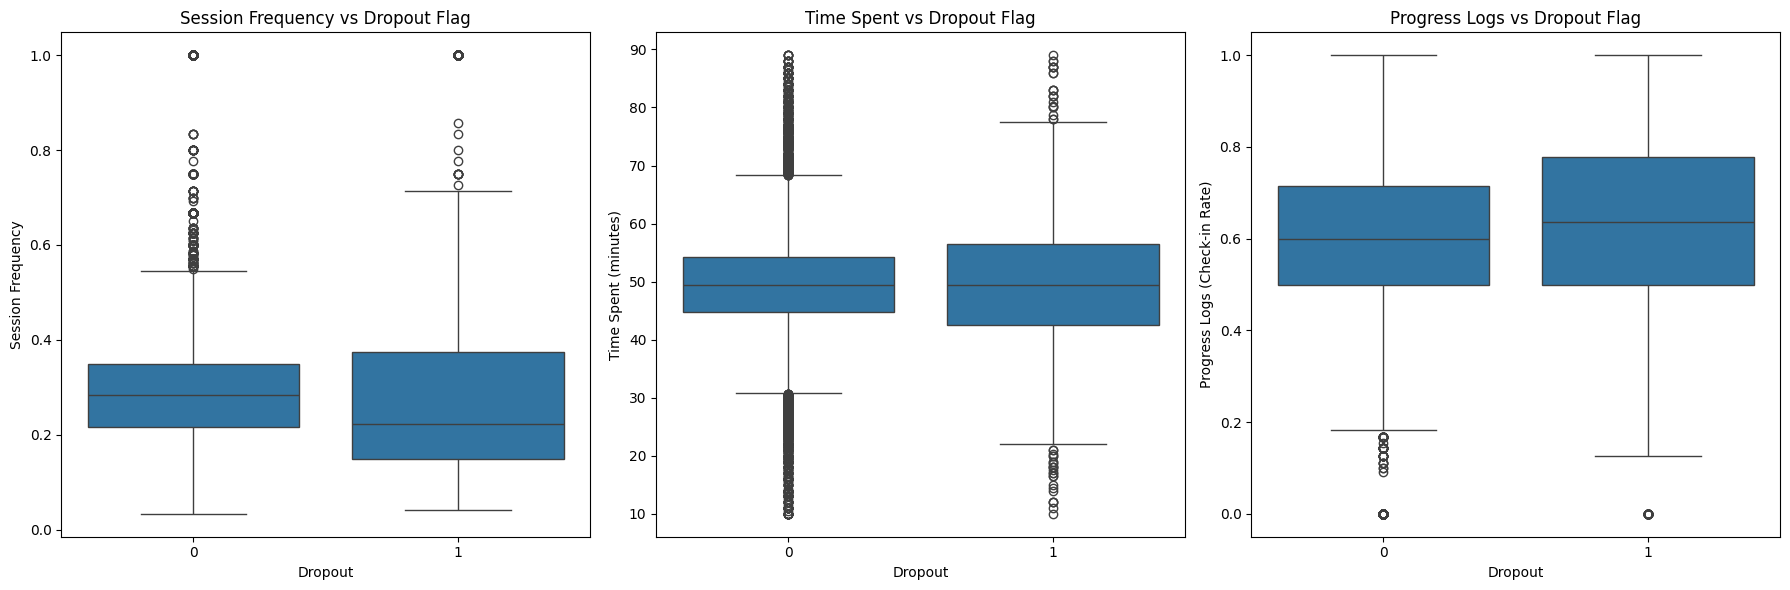

In [45]:
# Visualize the relationship between engineered features and dropoff_flag
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='dropoff_flag', y='session_frequency', data=model_df, ax=axes[0])
axes[0].set_title('Session Frequency vs Dropout Flag')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Session Frequency')

sns.boxplot(x='dropoff_flag', y='time_spent', data=model_df, ax=axes[1])
axes[1].set_title('Time Spent vs Dropout Flag')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Time Spent (minutes)')

sns.boxplot(x='dropoff_flag', y='progress_logs', data=model_df, ax=axes[2])
axes[2].set_title('Progress Logs vs Dropout Flag')
axes[2].set_xlabel('Dropout')
axes[2].set_ylabel('Progress Logs (Check-in Rate)')

plt.tight_layout()
plt.show()

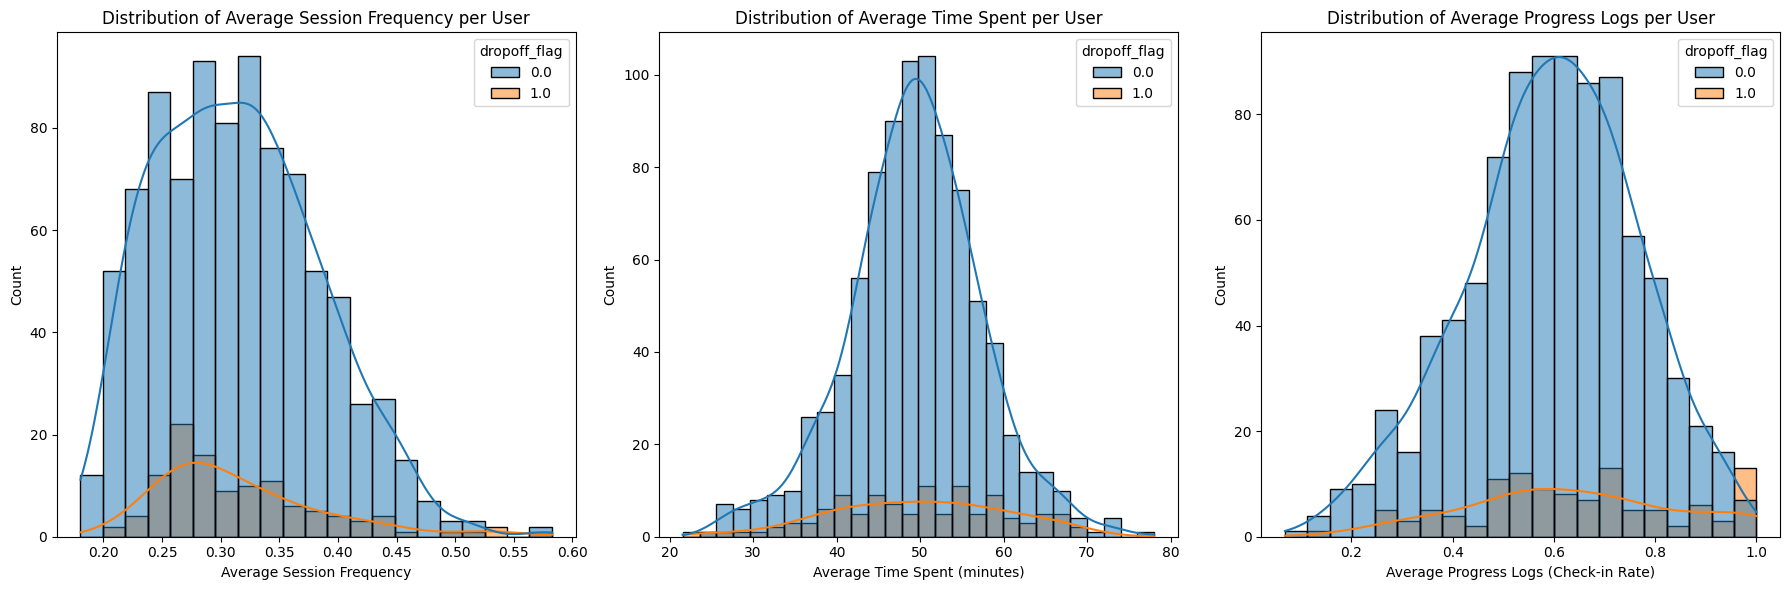

In [ ]:
user_grouped_df = df.groupby('user_id')[['session_frequency', 'time_spent', 'progress_logs', 'dropoff_flag']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=user_grouped_df, x='session_frequency', hue='dropoff_flag', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Average Session Frequency per User')
axes[0].set_xlabel('Average Session Frequency')
axes[0].set_ylabel('Count')

sns.histplot(data=user_grouped_df, x='time_spent', hue='dropoff_flag', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Average Time Spent per User')
axes[1].set_xlabel('Average Time Spent (minutes)')
axes[1].set_ylabel('Count')

sns.histplot(data=user_grouped_df, x='progress_logs', hue='dropoff_flag', kde=True, ax=axes[2])
axes[2].set_title('Distribution of Average Progress Logs per User')
axes[2].set_xlabel('Average Progress Logs (Check-in Rate)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## prediction


In [50]:
# it will be user level prediciton
# drop out risk on the level of the user not the session
user_grouped_df

,session_frequency,time_spent,progress_logs,dropoff_flag
user_id,,,,
U0001,0.417873,48.819440,0.473447,0.0
U0002,0.249025,59.189524,0.421071,0.0
U0003,0.409401,50.924380,0.454793,0.0
U0004,0.447314,58.647516,0.727753,1.0
U0005,0.381286,58.973333,0.296667,0.0
...,...,...,...,...
U0996,0.208427,49.217687,0.356463,0.0
U0997,0.265032,47.709293,0.487916,0.0
U0998,0.335638,49.682104,0.676317,0.0


In [87]:
df.describe()
df['dropoff_flag'].value_counts() # still imbalanced


,count
dropoff_flag,
0,16348
1,1077


In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = user_grouped_df[['session_frequency', 'time_spent', 'progress_logs']]
y = user_grouped_df['dropoff_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [89]:
# SMOTE
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, train_test_split


# Define the hyperparameter space
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced','balanced_subsample']
}

# Random search
rf = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='recall', 
    cv=5,
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_resampled, y_resampled)

# Best model
best_rf = rand_search.best_estimator_

# Predict on test set
y_pred_best = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best, digits=3))


              precision    recall  f1-score   support

         0.0      0.911     0.729     0.810       266
         1.0      0.172     0.441     0.248        34

    accuracy                          0.697       300
   macro avg      0.542     0.585     0.529       300
weighted avg      0.827     0.697     0.746       300



In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Define stratified folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(**best_rf.get_params()))
])

# Perform cross-validation with stratified folds
cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='recall')

print("Stratified CV Recall Scores (Fold by Fold):", cv_scores)
print(" Average Recall (dropout detection):", np.mean(cv_scores))


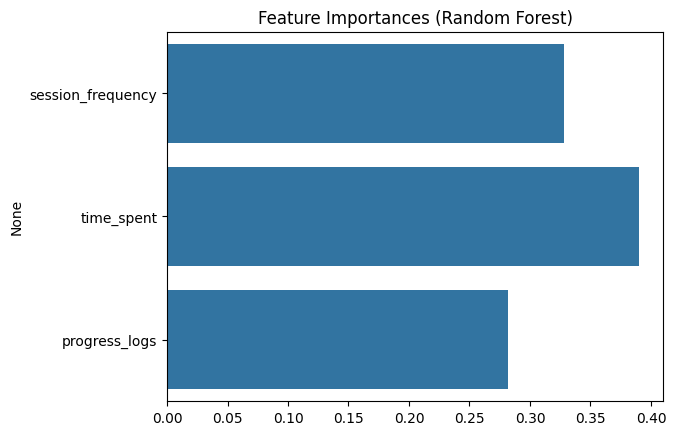

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = best_rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importances (Random Forest)")
plt.show()


In [114]:
from sklearn.ensemble import GradientBoostingClassifier
gb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

gb_pipeline.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = gb_pipeline.predict(X_test)

print(" Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

gb_scores = cross_val_score(gb_pipeline, X, y, cv=skf, scoring='recall')
print(" Gradient Boosting Recall Scores:", gb_scores)
print(" Avg Recall (Gradient Boosting):", np.mean(gb_scores))


 Confusion Matrix:
[[189  77]
 [ 17  17]]

 Classification Report:
              precision    recall  f1-score   support

         0.0      0.917     0.711     0.801       266
         1.0      0.181     0.500     0.266        34

    accuracy                          0.687       300
   macro avg      0.549     0.605     0.533       300
weighted avg      0.834     0.687     0.740       300

 Gradient Boosting Recall Scores: [0.31818182 0.47826087 0.47826087 0.30434783 0.52173913]
 Avg Recall (Gradient Boosting): 0.42015810276679844


In [115]:
import joblib

joblib.dump(gb_pipeline, 'dropout_gb_model.pkl')


['dropout_gb_model.pkl']

In [ ]:
gb_pipeline = joblib.load('dropout_gb_model.pkl')


session_freq = 2
time_spent = 20
checkin_rate = 0.5

user_input = np.array([[session_freq, time_spent, checkin_rate]])
prediction = gb_pipeline.predict(user_input)[0]
risk_score = gb_pipeline.predict_proba(user_input)[0][1]

if prediction == 1:
    print(f" Predicted: DROPOUT | Risk Score: {risk_score:.2f}")
else:
    print(f" Predicted: STAY | Risk Score: {risk_score:.2f}")


 Predicted: STAY | Risk Score: 0.10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


session_frequency: 0.3215
time_spent: 0.5203
progress_logs: 0.1582


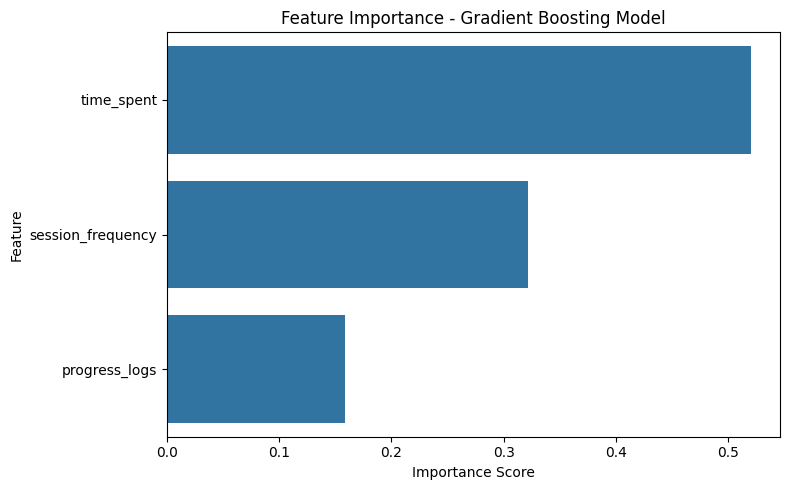

In [ ]:
gb_model = gb_pipeline.named_steps['gb']

importances = gb_model.feature_importances_

feature_names = X.columns
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")


import seaborn as sns

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importances_df, x='Importance', y='Feature')
plt.title('Feature Importance - Gradient Boosting Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## trying other models

In [84]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf, digits=3))

              precision    recall  f1-score   support

         0.0      0.907     0.733     0.811       266
         1.0      0.165     0.412     0.235        34

    accuracy                          0.697       300
   macro avg      0.536     0.572     0.523       300
weighted avg      0.823     0.697     0.746       300



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(class_weight='balanced', random_state=42)
log_model.fit(X_train_scaled, y_resampled)

# Predict
y_pred = log_model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[118 148]
 [ 15  19]]
              precision    recall  f1-score   support

         0.0      0.887     0.444     0.591       266
         1.0      0.114     0.559     0.189        34

    accuracy                          0.457       300
   macro avg      0.500     0.501     0.390       300
weighted avg      0.800     0.457     0.546       300



In [86]:
from xgboost import XGBClassifier

scale_pos_weight = len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])

xgb = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_resampled, y_resampled)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

         0.0      0.891     0.741     0.809       266
         1.0      0.127     0.294     0.177        34

    accuracy                          0.690       300
   macro avg      0.509     0.517     0.493       300
weighted avg      0.805     0.690     0.737       300



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [00:35:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

rf = RandomForestClassifier(**best_rf.get_params()) 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
gb = GradientBoostingClassifier(random_state=42)

voting_model = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb),
    ('gb', gb)
], voting='soft')

voting_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('voting', voting_model)
])

voting_scores = cross_val_score(voting_pipeline, X, y, cv=skf, scoring='recall')
print(" Voting Ensemble Recall Scores:", voting_scores)
print(" Avg Recall (Voting Ensemble):", np.mean(voting_scores))

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:04:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:04:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:04:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [01:04:21] WARNING: /w

 Voting Ensemble Recall Scores: [0.22727273 0.47826087 0.26086957 0.2173913  0.47826087]
 Avg Recall (Voting Ensemble): 0.33241106719367586
